# Building metacells with [SEACell](https://github.com/dpeerlab/SEACells)

An example of building *metacells* using the [SEACell](https://github.com/dpeerlab/SEACells) algorithm. 


## Imports

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


import SEACells
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../Py/') # make a MC_metrics.py script to stote metric functions
import mc_QC

## Parameter
Requested graining level

In [4]:
## Parameters
I = 2
proj_name = ["cell_lines", "3k_pbmc"][1]

annotation_label = {'cell_lines':'cell_line',
                   '3k_pbmc':'louvain'}[proj_name]

gamma = [10, 20, 30, 50, 75, 100][I] # the requested graing level


MC_tool = "SEACell"


## Load data

In [5]:
# Load data pre-filtered data

data_folder = os.path.join("../../data/", proj_name)
ad = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))

## Data processing 
In contrast to [Metacell-2](), SEACells build metacells based on processed data and takes as an input dimensionally reduced data (i.e., PCA for scRNA-seq data). Thus, we first compute PCA for our data usign the same set of genes used in the main [tutorial]()

In [6]:
# Save count as a separate layer
ad.layers['counts'] = ad.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [7]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1000)


In [8]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(ad, n_comps=n_comp, use_highly_variable=True)

# Compute UMAP for visualization 
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(ad)

## Computing metacells 

In [9]:
## User defined parameters
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10      # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                          # the remainder of cells are selected by greedy selection
    
n_iter = 20

In [10]:
# The number of SEACells is computed as a ratio between the number of single cells and the desired graining level
n_SEACells = int(ad.shape[0]/gamma) 

model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)


Welcome to SEACells!


Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2638 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2638 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2638 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 74 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 385.18it/s]

Selecting 13 cells from greedy initialization.


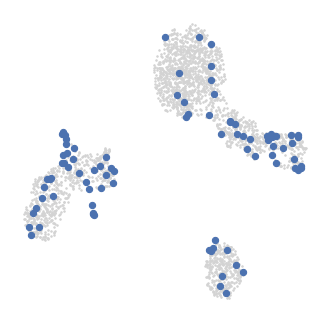

In [11]:
model.construct_kernel_matrix()
M = model.kernel_matrix

# Initialize archetypes
model.initialize_archetypes()
    
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad, model, plot_basis='X_umap')

In [12]:
model.fit(min_iter=10, max_iter=n_iter)
    
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')


Randomly initialized A matrix.
Setting convergence threshold at 0.00086
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.


RuntimeWarning: Warning: Algorithm has not converged - you may need to increase the maximum number of iterations

In [13]:
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 26 iterations


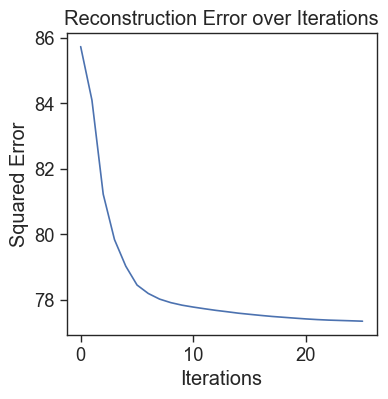

100%|██████████████████████████████████████████| 87/87 [00:00<00:00, 386.90it/s]


In [14]:
# Check for convergence 
model.plot_convergence()
    
membership = model.get_hard_assignments()
    
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
    

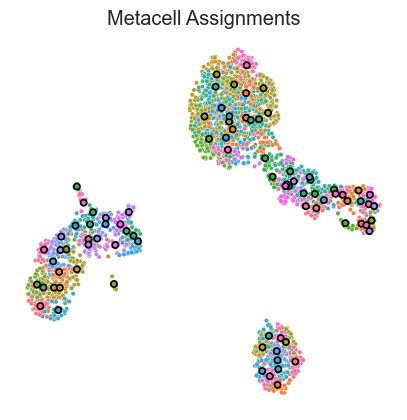

In [15]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

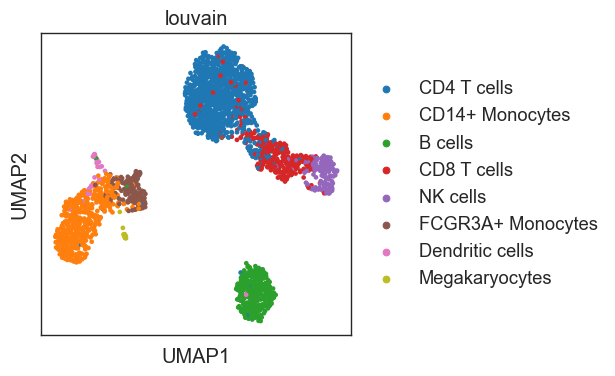

In [28]:
sc.pl.umap(ad, color=['louvain'])

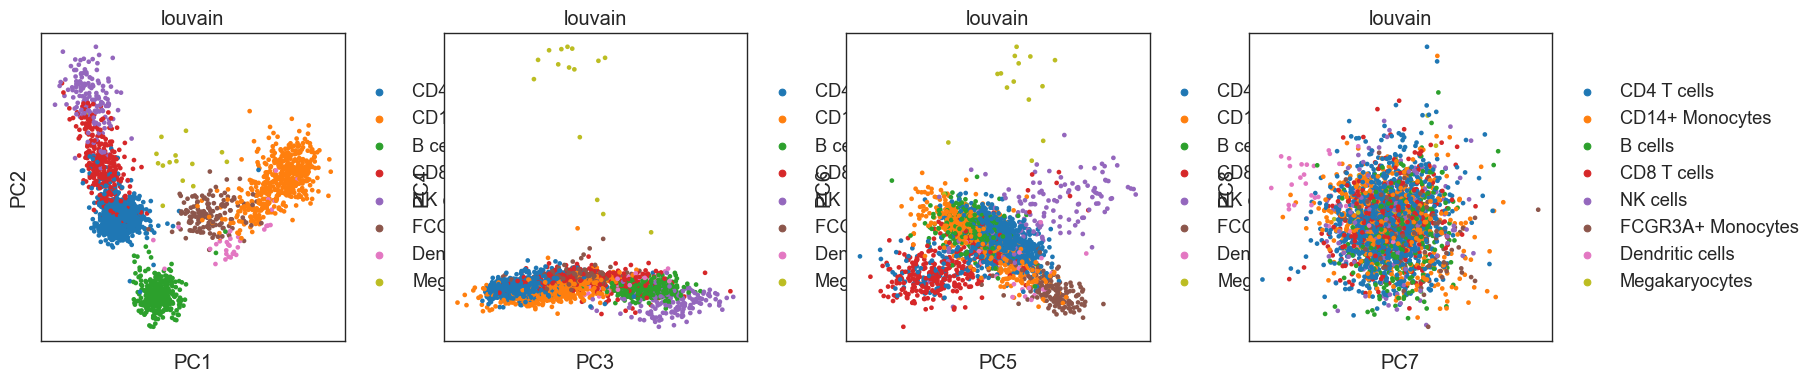

In [45]:
sc.pl.pca(ad, color=['louvain'], components=['1,2', '3,4', '5,6', '7,8'])

In [16]:
d = {x: i+1 for i, x in enumerate(SEACell_ad.obs_names)}
# make a membership (as in SCimplify() from SuperCell) vector
ad.obs.merge(membership)
ad.obs['membership'] = [d[x] for x in membership.SEACell]
print(ad.obs)


                  n_genes  percent_mito  n_counts          louvain  \
index                                                                
AAACATACAACCAC-1      781      0.030178    2421.0      CD4 T cells   
AAACATTGAGCTAC-1     1352      0.037936    4903.0          B cells   
AAACATTGATCAGC-1     1131      0.008897    3149.0      CD4 T cells   
AAACCGTGCTTCCG-1      960      0.017431    2639.0  CD14+ Monocytes   
AAACCGTGTATGCG-1      522      0.012245     981.0         NK cells   
...                   ...           ...       ...              ...   
TTTCGAACTCTCAT-1     1155      0.021104    3461.0  CD14+ Monocytes   
TTTCTACTGAGGCA-1     1227      0.009294    3447.0          B cells   
TTTCTACTTCCTCG-1      622      0.021971    1684.0          B cells   
TTTGCATGAGAGGC-1      454      0.020548    1024.0          B cells   
TTTGCATGCCTCAC-1      724      0.008065    1985.0      CD4 T cells   

                     SEACell  membership  
index                                     
AAA

In [17]:
## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
SEACell_ad.uns = ad.uns.copy()
SEACell_ad.uns['sc.obs'] = ad.obs.copy()

SEACell_ad.var['feature_gene'] = ad.var['highly_variable'].astype(int)
SEACell_ad.obs = SEACell_ad.obs.join(pd.DataFrame.from_dict(d, orient='index', columns=['membership']))
SEACell_ad.obs['gamma'] = gamma
SEACell_ad.obs['gamma_obtained'] = round(ad.shape[0]/SEACell_ad.shape[0])
SEACell_ad.obs['MC_tool'] = MC_tool


SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool
SEACell-41,1,30,30,SEACell
SEACell-23,2,30,30,SEACell
SEACell-6,3,30,30,SEACell
SEACell-71,4,30,30,SEACell
SEACell-66,5,30,30,SEACell
...,...,...,...,...
SEACell-48,83,30,30,SEACell
SEACell-30,84,30,30,SEACell
SEACell-7,85,30,30,SEACell
SEACell-83,86,30,30,SEACell


In [18]:
SEACell_ad.X.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
SEACell_ad.uns['sc.obs']

,n_genes,percent_mito,n_counts,louvain,SEACell,membership
index,,,,,,
AAACATACAACCAC-1,781,0.030178,2421.0,CD4 T cells,SEACell-41,1
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,SEACell-23,2
AAACATTGATCAGC-1,1131,0.008897,3149.0,CD4 T cells,SEACell-6,3
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,SEACell-71,4
AAACCGTGTATGCG-1,522,0.012245,981.0,NK cells,SEACell-66,5
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3461.0,CD14+ Monocytes,SEACell-85,69
TTTCTACTGAGGCA-1,1227,0.009294,3447.0,B cells,SEACell-52,9
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,SEACell-14,54


### Metacell quality metrics 

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


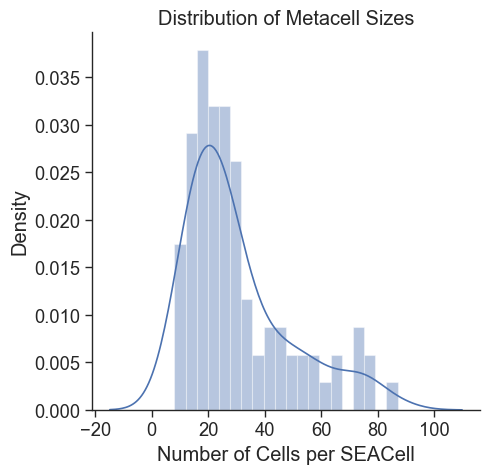

,membership,gamma,gamma_obtained,MC_tool,size
SEACell-41,1,30,30,SEACell,35
SEACell-23,2,30,30,SEACell,45
SEACell-6,3,30,30,SEACell,60
SEACell-71,4,30,30,SEACell,26
SEACell-66,5,30,30,SEACell,10
...,...,...,...,...,...
SEACell-48,83,30,30,SEACell,15
SEACell-30,84,30,30,SEACell,11
SEACell-7,85,30,30,SEACell,13
SEACell-83,86,30,30,SEACell,14


In [20]:
mc_size = SEACells.plot.plot_SEACell_sizes(ad, bins=20)

SEACell_ad.obs = pd.merge(SEACell_ad.obs, mc_size, left_index=True, right_index=True)
SEACell_ad.obs

In [21]:
ad.obs[annotation_label]

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

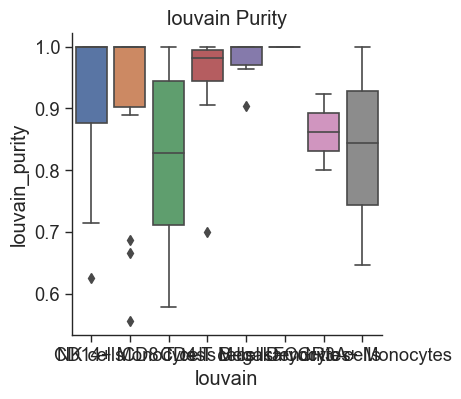

In [22]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, annotation_label)

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y=f'{annotation_label}_purity', x = annotation_label)
plt.title(f'{annotation_label} Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

SEACell_ad.obs = pd.merge(SEACell_ad.obs, SEACell_purity, left_index=True, right_index=True)


In [23]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:7]
SEACell_ad.obs


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity
SEACell-41,1,30,30,SEACell,35,CD8 T cells,0.685714
SEACell-23,2,30,30,SEACell,45,B cells,0.977778
SEACell-6,3,30,30,SEACell,60,CD4 T cells,0.933333
SEACell-71,4,30,30,SEACell,26,CD14+ Monocytes,0.961538
SEACell-66,5,30,30,SEACell,10,NK cells,1.000000
...,...,...,...,...,...,...,...
SEACell-48,83,30,30,SEACell,15,CD14+ Monocytes,1.000000
SEACell-30,84,30,30,SEACell,11,NK cells,1.000000
SEACell-7,85,30,30,SEACell,13,NK cells,1.000000
SEACell-83,86,30,30,SEACell,14,CD8 T cells,1.000000


In [24]:
import importlib
importlib.reload(mc_QC)

compactness_PCA = mc_QC.compactness(ad, 'X_pca', DO_DC = False, name = 'Compactness_PCA', n_comp=n_comp)['Compactness_PCA']
compactness_DC  = mc_QC.compactness(ad, 'X_pca', DO_DC = True, name = 'Compactness_DC', n_comp=n_comp)['Compactness_DC']

SEACell_ad.obs = SEACell_ad.obs.join(compactness_PCA)
SEACell_ad.obs = SEACell_ad.obs.join(compactness_DC)

separation_PCA = mc_QC.separation(ad, 'X_pca', DO_DC = False, name = 'Separation_PCA', n_comp=n_comp)['Separation_PCA']
separation_DC  = mc_QC.separation(ad, 'X_pca', DO_DC = True, name = 'Separation_DC', n_comp=n_comp)['Separation_DC']

SEACell_ad.obs = SEACell_ad.obs.join(separation_PCA)
SEACell_ad.obs = SEACell_ad.obs.join(separation_DC)

SEACell_ad.obs


Determing nearest neighbor graph...
Determing nearest neighbor graph...


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
SEACell-41,1,30,30,SEACell,35,CD8 T cells,0.685714,0.144421,0.015234,1.118813,0.116005
SEACell-23,2,30,30,SEACell,45,B cells,0.977778,0.119110,0.013969,1.029837,0.066862
SEACell-6,3,30,30,SEACell,60,CD4 T cells,0.933333,0.168783,0.235810,1.021042,0.446622
SEACell-71,4,30,30,SEACell,26,CD14+ Monocytes,0.961538,0.181212,0.034020,1.122577,0.321278
SEACell-66,5,30,30,SEACell,10,NK cells,1.000000,0.230514,0.006562,1.532130,0.339337
...,...,...,...,...,...,...,...,...,...,...,...
SEACell-48,83,30,30,SEACell,15,CD14+ Monocytes,1.000000,0.096446,0.018183,1.160845,0.426517
SEACell-30,84,30,30,SEACell,11,NK cells,1.000000,0.181115,0.004950,1.382166,0.071278
SEACell-7,85,30,30,SEACell,13,NK cells,1.000000,0.175329,0.000630,1.382166,0.136110
SEACell-83,86,30,30,SEACell,14,CD8 T cells,1.000000,0.127160,0.029062,1.280749,0.401925


In [29]:
# compute extra PC to evaluate performance of compactness and separation outside the n_comp used for MC construction
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)
ad.obsm['X_pca'].shape

(2638, 50)

### Compute *compactness* for a range of latent space components 

In [30]:
QC_compactness = pd.DataFrame()

# Compactness

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    
    compactness_PCA_i = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = 'membership')
    compactness_DC_i  = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = 'membership')
    
    QC_compactness = pd.concat([QC_compactness, compactness_PCA_i, compactness_DC_i], ignore_index=True)
QC_compactness


2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,compactness,low_dim_embedding,n_comp,membership
0,0.147373,X_pca,2,1
1,0.091555,X_pca,2,2
2,0.130336,X_pca,2,3
3,0.142556,X_pca,2,4
4,0.256563,X_pca,2,5
...,...,...,...,...
2605,0.002923,DC,30,83
2606,0.001032,DC,30,84
2607,0.000844,DC,30,85
2608,0.002220,DC,30,86


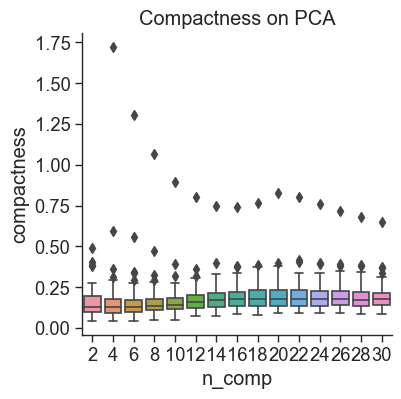

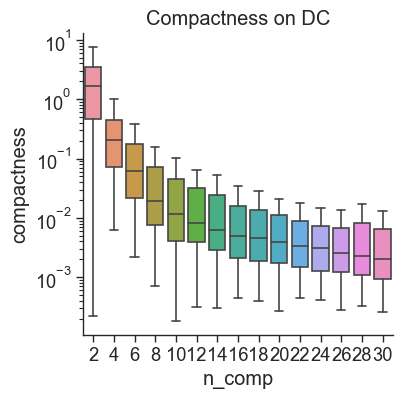

In [31]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'X_pca'], y='compactness', x = 'n_comp')
#plt.yscale('log')
plt.title('Compactness on PCA')
sns.despine()
plt.show()
plt.close()


plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'DC'], y='compactness', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Compactness on DC')
sns.despine()
plt.show()
plt.close()

### Compute *separation* for a range of latent space components 

In [32]:
importlib.reload(mc_QC)
QC_separation = pd.DataFrame()

#Separation

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    sep_PCA_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = 'membership')
    sep_DC_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = 'membership')
    
    
    QC_separation = pd.concat([QC_separation, sep_PCA_i, sep_DC_i], ignore_index=True)
QC_separation

2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,separation,low_dim_embedding,n_comp,membership
0,0.267912,X_pca,2,1
1,0.416721,X_pca,2,2
2,0.187051,X_pca,2,3
3,0.259679,X_pca,2,4
4,0.288075,X_pca,2,5
...,...,...,...,...
2605,0.289637,DC,30,83
2606,0.123620,DC,30,84
2607,0.095214,DC,30,85
2608,0.159373,DC,30,86


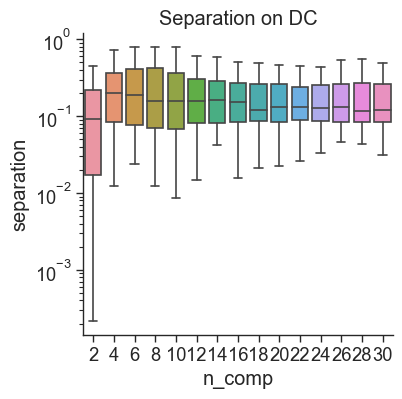

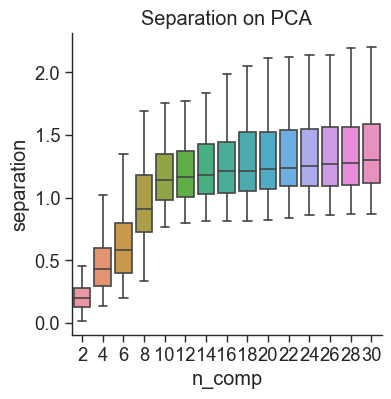

In [33]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'DC'], y='separation', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Separation on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'X_pca'], y='separation', x = 'n_comp', showfliers = False)
#plt.yscale('log')
plt.title('Separation on PCA')
sns.despine()
plt.show()
plt.close()

In [34]:
QC = QC_compactness.merge(QC_separation, on=['low_dim_embedding', 'n_comp', 'membership'])

QC = SEACell_ad.obs.iloc[:,:7].merge(QC, on = 'membership')

QC

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,compactness,low_dim_embedding,n_comp,separation
0,1,30,30,SEACell,35,CD8 T cells,0.685714,0.147373,X_pca,2,0.267912
1,1,30,30,SEACell,35,CD8 T cells,0.685714,2.511713,DC,2,0.285550
2,1,30,30,SEACell,35,CD8 T cells,0.685714,0.144691,X_pca,4,0.315932
3,1,30,30,SEACell,35,CD8 T cells,0.685714,0.772332,DC,4,0.388712
4,1,30,30,SEACell,35,CD8 T cells,0.685714,0.129145,X_pca,6,0.404510
...,...,...,...,...,...,...,...,...,...,...,...
2605,87,30,30,SEACell,28,CD14+ Monocytes,1.000000,0.001442,DC,26,0.177885
2606,87,30,30,SEACell,28,CD14+ Monocytes,1.000000,0.343538,X_pca,28,1.905825
2607,87,30,30,SEACell,28,CD14+ Monocytes,1.000000,0.001215,DC,28,0.171361
2608,87,30,30,SEACell,28,CD14+ Monocytes,1.000000,0.339902,X_pca,30,1.929892


Text(0.3, 0, 'r = 0.5873')

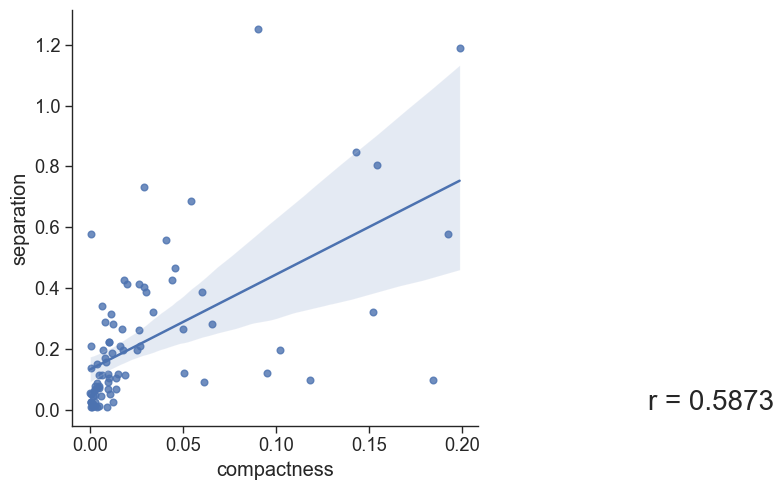

In [35]:
import scipy
df = QC[(QC['low_dim_embedding'] == 'DC') & (QC['n_comp'] == 10)]
#df['size'] = mc_size.cell_line
df = df[(df['separation']<100) & (df['compactness']<.2)]
r = df.compactness.corr(df.separation)

#sns.scatterplot(x="compactness", y="separation", data=df)
sns.lmplot(x="compactness", y="separation", data=df)

#add correlation coefficient to plot
plt.text(.3,0, 'r = ' + str(round(r, 4)), fontsize=20)


In [36]:
mc_INV = mc_QC.mc_inner_normalized_var(ad, 'SEACell')

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/pandas/core/arraylike.py:490: RuntimeWarning: divide by zero encountered in reciprocal
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [37]:
mc_INV_val = mc_INV.quantile([0.05, 0.5, 0.95], axis=1, numeric_only=True)
mc_INV_val = pd.DataFrame(mc_INV_val.transpose()).set_axis(['INV_5', 'INV_50','INV_95'], axis=1, inplace=False)
#mc_INV_val = pd.DataFrame.from_dict(mc_INV_val, orient='index', columns=['INV_95'])
SEACell_ad.obs = SEACell_ad.obs.join(mc_INV_val)

In [38]:
SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC,INV_5,INV_50,INV_95
SEACell-41,1,30,30,SEACell,35,CD8 T cells,0.685714,0.144421,0.015234,1.118813,0.116005,0.000116,0.001208,0.085613
SEACell-23,2,30,30,SEACell,45,B cells,0.977778,0.119110,0.013969,1.029837,0.066862,0.000074,0.000891,0.060130
SEACell-6,3,30,30,SEACell,60,CD4 T cells,0.933333,0.168783,0.235810,1.021042,0.446622,0.000013,0.000521,0.053047
SEACell-71,4,30,30,SEACell,26,CD14+ Monocytes,0.961538,0.181212,0.034020,1.122577,0.321278,0.000147,0.001544,0.147883
SEACell-66,5,30,30,SEACell,10,NK cells,1.000000,0.230514,0.006562,1.532130,0.339337,0.002227,0.011740,0.268681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEACell-48,83,30,30,SEACell,15,CD14+ Monocytes,1.000000,0.096446,0.018183,1.160845,0.426517,0.000289,0.001860,0.112697
SEACell-30,84,30,30,SEACell,11,NK cells,1.000000,0.181115,0.004950,1.382166,0.071278,0.000623,0.007187,0.207758
SEACell-7,85,30,30,SEACell,13,NK cells,1.000000,0.175329,0.000630,1.382166,0.136110,0.002058,0.008339,0.220786
SEACell-83,86,30,30,SEACell,14,CD8 T cells,1.000000,0.127160,0.029062,1.280749,0.401925,0.000800,0.004392,0.164183


In [39]:
SEACell_ad.uns['QC_separation_compactness_PC_range'] = QC

## Saving data for the downstream analysis

In [40]:
meth_name = 'seacells'
SEACell_ad.write(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}.h5ad'))
SEACell_ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_metacell_obs.csv'))
ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_singlecell_obs.csv'))
QC.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_QC.csv'))


In [41]:
gamma

30

In [37]:
I

4